In [1]:
import os
import pickle
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sales_predictor import SalesPredictor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [14, 8]

### Read Data


In [2]:
data_path = os.path.join("data", "sales_data.csv")

Read data.

In [3]:
df = pd.read_csv(data_path, index_col=0)
df.head()

,Price,Price Component,Sales
Week,,,
2015-10-18,287.270059,56.291389,104.119809
2015-10-25,575.357153,4.435712,47.394908
2015-11-01,465.996971,24.120545,68.721914
2015-11-08,399.329242,36.120736,89.680902
2015-11-15,178.009320,75.958322,125.468075


<AxesSubplot:xlabel='Week'>

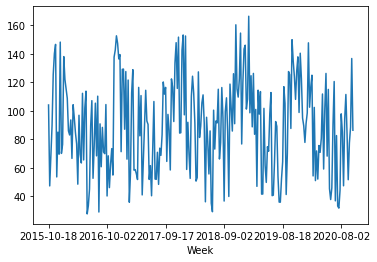

In [4]:
df["Sales"].plot()

Split dataset into train and test parts.

In [5]:
train_set_ratio = 0.8

# TODO: Your code here
def split_into_data_and_labels(df_sample):
    return df_sample[['Price']], df_sample[['Sales']]

df_train, df_test = train_test_split(df, test_size=1-train_set_ratio, random_state=42, shuffle=False)

X_df_train, Y_df_train = split_into_data_and_labels(df_train)
X_df_test, Y_df_test = split_into_data_and_labels(df_test)

print(f"Train set size: {df_train.shape[0]}; test set size: {df_test.shape[0]}")

Train set size: 208; test set size: 53


### Train Forecasting Models

#### Let's see what is the pattern of the sales data we have

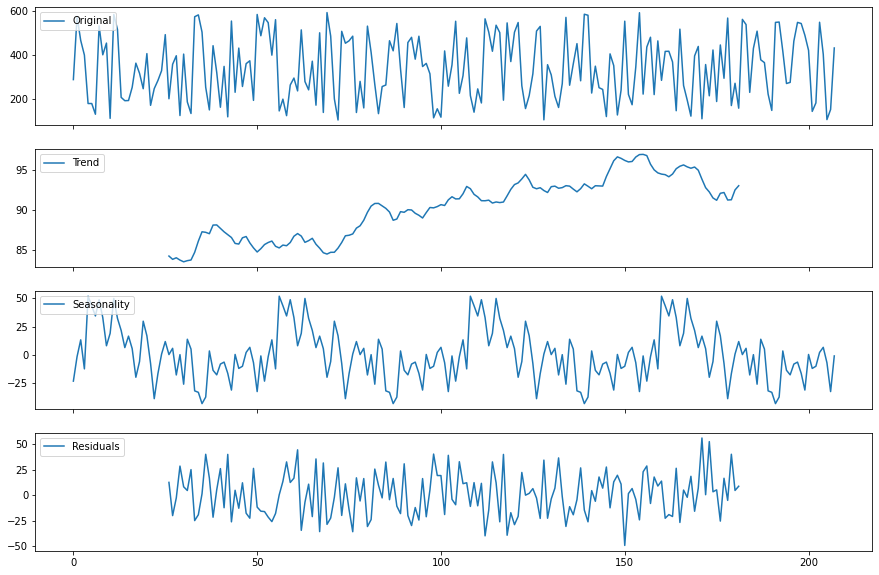

In [6]:
decomposition = seasonal_decompose(x=Y_df_train.values, model='additive', period=52)
estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(X_df_train.values, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [7]:
estimated_residual = pd.Series(estimated_residual, index=X_df_train.index).dropna().to_numpy()
estimated_trend = pd.Series(estimated_trend, index=X_df_train.index).dropna().to_numpy()

print("Seasonal decomposition:\n", estimated_seasonal[:2],\
      "\n\nResiduals:\n", estimated_residual[:2], "\n\nTrend decomposition:\n", estimated_trend[:2])

Seasonal decomposition:
 [-23.55305462  -1.8316234 ] 

Residuals:
 [ 12.58610094 -19.90197326] 

Trend decomposition:
 [84.2815638  83.87244656]


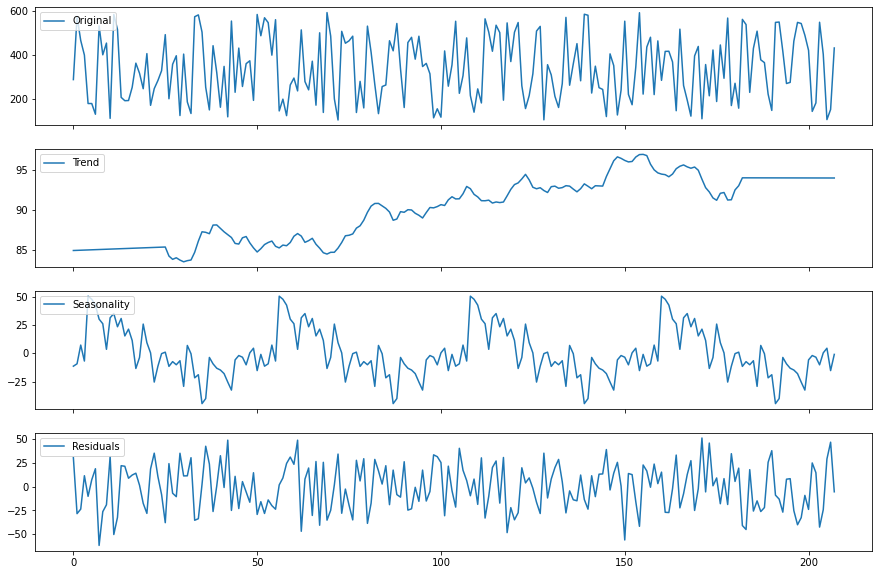

In [8]:
decomposition2 = seasonal_decompose(x=Y_df_train.values, model='additive', period=52, extrapolate_trend='freq')
estimated_trend2 = decomposition2.trend
estimated_seasonal2 = decomposition2.seasonal
estimated_residual2 = decomposition2.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(X_df_train.values, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend2, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal2, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual2, label='Residuals')
axes[3].legend(loc='upper left');

#### Conclusion: Extrapolation shows good results, so we would add it.

#### While predictiong sales
We want to avoid trend and seasonality. We will create a class SalesPredictor, where we remove trend and seasonality; fit model just based on residuals and then add seasonality to predict the actual sales.\
We also want to take care of the size of X, as since now Y for training would be our residuals, so we wouldn't have some data at the edges.

Implement Mean Absolute Percentage Error.

In [9]:
# TODO: Your code here
def mape(y, y_hat):
    # Colud be also this formuls:
    # return np.mean(np.abs((y.values.flatten() - y_hat) / y.values.flatten())) * 100
    return mean_absolute_error(y, y_hat)

Function that converts strings to week numbers. It's useful while inference of SalesPredictor model, since it receives week number as a first argument.

In [10]:
def weeks_from_date(date_strings):
    return pd.Series(date_strings) \
             .apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").isocalendar()[1]) \
             .to_numpy()

Implement model validation function, using sliding window cross-validation approach. Use MAPE score as a performance metric.

In [11]:
# TODO: Your code here

def validate(model, df, folds_number, samples_per_fold, period):
    X, y = split_into_data_and_labels(df)
    tscv = TimeSeriesSplit(n_splits=folds_number, max_train_size=period-samples_per_fold)
    
    prev_train_index = np.array([])
    for train_index, test_index in tscv.split(X):
        train_index = np.concatenate((train_index, prev_train_index), axis=0)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#         print("size of training = ", len(X_train), "; test = ", len(X_test))
        
        # we want to predict seasonality, so we take each year as the one to learn
        if len(X_train) > period * 2:
            sp = SalesPredictor(period, model)
            sp.fit(X_train, y_train.values)
            
            
            y_hat = sp.predict(X_test.index.to_numpy(), X_test.to_numpy())
            print("\tMAPE: ", mape(y_test, y_hat), "\n")
            
        prev_train_index = np.concatenate((train_index, test_index), axis=0)

    # Plot outputs
    fig, ax = plt.subplots()
    ax.set_title('Distribution of actual data and predicted values for ' + str(model))
    ax.scatter(X_test.to_numpy(), y_test.to_numpy(),  color='black')
    ax.scatter(X_test.to_numpy(), y_hat, color='blue', linewidth=3)
    plt.show;

Validate different linear models, such that linear regression, ridge and lasso. Try nonlinear estimators.
Can you explain why linear estimators perform better?
Use SalesPredictor class for defining models. It allows incapsulating seasonality extraction procedure.

Model:  LinearRegression() 

	MAPE:  21.465053374970626 

	MAPE:  28.915228271502386 

	MAPE:  16.578657857462957 

Model:  Lasso() 

	MAPE:  21.467315354202565 

	MAPE:  28.91623443955414 

	MAPE:  16.581688761997302 

Model:  RandomForestRegressor() 

	MAPE:  24.80460735796634 

	MAPE:  30.209519708464068 

	MAPE:  23.808098504519187 

Model:  SVR() 

	MAPE:  24.055189414364904 

	MAPE:  31.05257314612589 

	MAPE:  19.26965185860424 



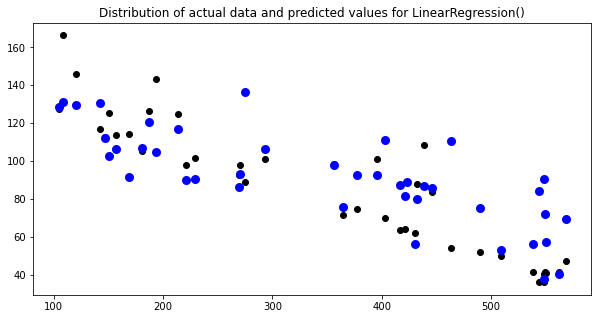

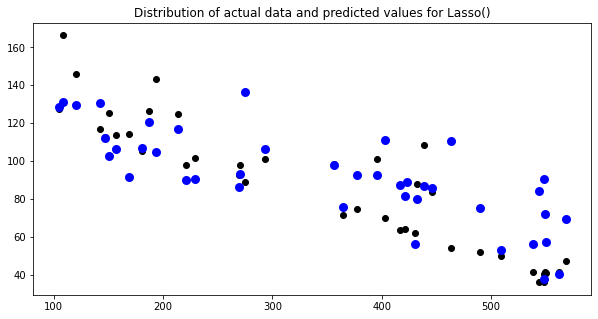

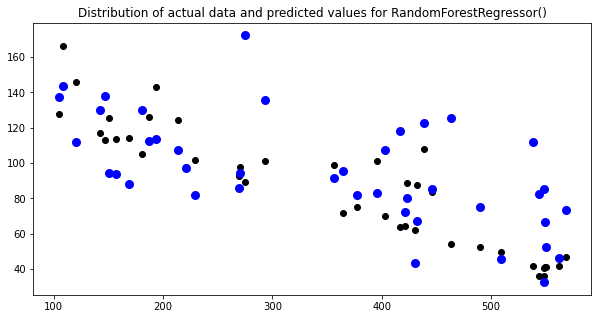

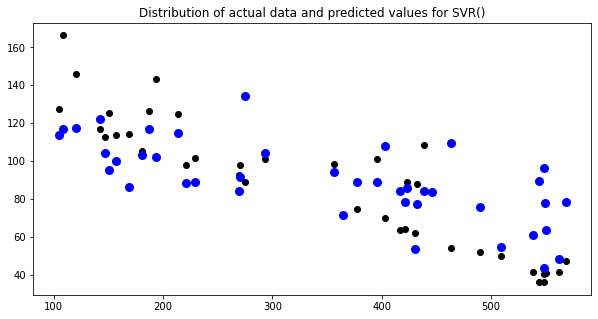

In [12]:
period = 52
folds_number = 4
samples_per_fold = 12

# TODO: Your code here
lin_reg_model = LinearRegression()
lasso_model = Lasso()
rand_forest_model = RandomForestRegressor()
svm_model = SVR()
models = [lin_reg_model, lasso_model, rand_forest_model, svm_model]

plt.rcParams['figure.figsize'] = 10, 5
for model in models:
    print("Model: ", model, "\n")
    validate(model, df_train, folds_number, samples_per_fold, period)
    

#### Conclusion:
We can see that Linear and Lasso regressions are showing almost the same results, while Random Forest is performing a bit worse. Also SVR (SVM) model shows good result.\
Actually we have a straightforward linear dependancy, where the **Sales** depends on **Prices**, so that's why linear estimators perform good results.\
We can see that the data we predict is a bit lower than the actual data, this happens because of trend and seasonality.\
We couldn't remove these two metrics from `y_test`, as it's size 41, when to remove we must have data bigger than `period*2`.

In [13]:
best_model = SalesPredictor(period, LinearRegression())

In [20]:
best_model.seasonal.to_numpy()[:52]

array([ 87.42628432,  86.34913111,  97.41395444,  82.79722022,
       132.54309333, 132.27812106, 120.32435789, 118.88695082,
       112.35235589,  88.73673806, 109.73752374, 110.33102372,
       103.72044622, 111.21445648, 108.83586863, 104.65681311,
        99.31720271,  81.0177555 ,  74.69620299, 108.0187468 ,
        84.6274235 ,  81.48548343,  56.85688778,  72.94990598,
        81.07393838,  84.06969857,  79.27747676,  71.70509672,
        78.10763467,  85.57614531,  55.6621677 ,  94.17529526,
        74.45695454,  56.85064916,  62.14135   ,  51.73034567,
        61.32540967,  73.76181836,  79.691229  ,  66.87511852,
        64.81119337,  64.39925866,  68.88087933,  60.28123921,
        73.50550753,  86.02401891,  89.15698289,  78.50498525,
        79.86849037,  87.76695394,  73.77312921,  95.40923307])

### Evaluate on Test set


Make predictions on test set.

In [15]:
# TODO: Your code here

best_model.fit(X_df_train, Y_df_train.values)

df_test["Sales Hat"] = best_model.predict(X_df_test.index.to_numpy(), X_df_test.to_numpy())

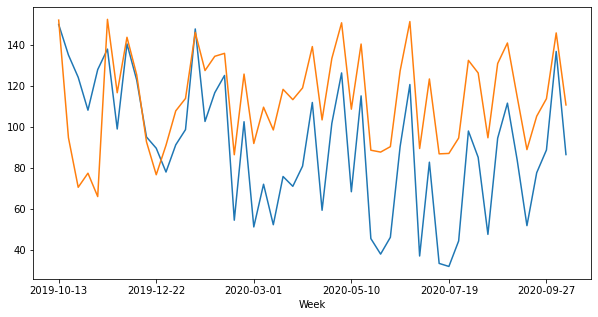

In [16]:
df_test["Sales"].plot()
df_test["Sales Hat"].plot();

In [17]:
print(f"MAPE = {mape(df_test['Sales'], df_test['Sales Hat'])}")

MAPE = 30.874873265717092


### Save Model

In [18]:
best_model.fit(df[["Price"]], df["Sales"])

In [19]:
model_path = os.path.join("data", "sales_model.pkl")
pickle.dump(best_model, open(model_path, "wb"))

### Conclusion:
Model shows the pattern of the sales, so we have a good estimator - Linear Regressor.